In [1]:
import numpy as np
import matplotlib.pyplot as plt
seed = 1923
print (f"User seed is set to {seed}")

import scipy.interpolate as interpolate

User seed is set to 1923


In [2]:
print ("""Make sure to check later which 
    functions you can use and which you have to write yourself""")
print ("\n")

print ("Question: can we use np arrays for division etc?")

Make sure to check later which 
    functions you can use and which you have to write yourself


Question: can we use np arrays for division etc?


# Question 1 Preparing some useful routines

In [3]:
def fac(k):
    """Returns factorial of k. Note: 0! is defined as 1"""
    if k == 0:
        return 1
    ans = k
    for x in range(1,k):
        ans *= x
    return ans

In [4]:
def poisson_probability(k,lambd):
    """
    Returns the Poisson probability, i.e., the probability of 'k' 
    occurences if 'lambd' is the occurence rate, per interval. 
    """
    return (lambd**k * np.exp(-1*lambd))/(fac(k))

## Output $P_{\lambda}(k)$ to at least 6 significant digits for following values

In [5]:
# Output P_{\lambda}(k) to at least 6 significant digits for these values
lambdas = [1,5,3,2.6]
ks = [0,10,20,40]

for k, lambd in zip(ks, lambdas):
    print(f'P_{lambd}({k}) = {poisson_probability(k,lambd):.5e}')


P_1(0) = 3.67879e-01
P_5(10) = 1.81328e-02
P_3(20) = 7.13538e-11
P_2.6(40) = 3.61512e-33


### Write a random number generator that returns a random floating-point number between 0 and 1. At minimum, use some combination of an (M)LCG and a 64-bit XOR-shift

In [6]:
class RandomGenerator(object):
    """
    Random generator should be an object because it maintains
    internal state between calls.
    """
    def __init__(self, seed):
        # make sure the everyhing is an unsigned 64 bit integer
        dtyp = np.uint64
        # the seed for the LGC
        self.X1 = dtyp(seed)
        # the seed for the XORshift
        self.X2 = dtyp(seed)
        
        self.max_value = dtyp(2**64 - 1)
        
        # LCG values from Numerical Recipies
        self.a = dtyp(1664525)
        self.c = dtyp(1013904223)
        self.m = dtyp(2**32)
        
        # 64 bit XOR shift values from Numerical Recipies
        self.a1, self.a2, self.a3 = dtyp(21), dtyp(35), dtyp(4)
        
    def lincongen(self, X):    
        return (self.a*X+self.c) % self.m

    def XORshift64(self, X):
        if X == 0:
            raise ValueError("Seed cannot be zero")
        X = X ^ (X >> self.a1)
        X = X ^ (X << self.a2)
        X = X ^ (X >> self.a3)
        
        return X
    
    def get_randomnumber(self):
        """
        Combine LCG and XORshift to produce random float 
        between 0 and 1
        """
        self.X1 = self.lincongen(self.X1)
        self.X2 = self.XORshift64(self.X2)
        
        # output is XOR of these numbers
        
        return (self.X1^self.X2)/self.max_value
    
        


In [7]:
RNGESUS = RandomGenerator(seed=seed)
print (RNGESUS.get_randomnumber())
print (RNGESUS.get_randomnumber())

3.805728939112855e-06
0.05873143700074865


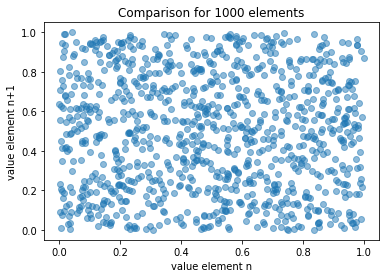

In [8]:
all_randnum = []
for i in range(1000):
    # Could vectorize? 
    all_randnum.append(RNGESUS.get_randomnumber())
    
plt.plot(all_randnum,np.roll(all_randnum,1),'o',alpha=0.5)
plt.title(f'Comparison for {len(all_randnum)} elements')
plt.xlabel('value element n')
plt.ylabel('value element n+1')
plt.savefig('q1b1.png')
plt.show();

Is np.linspace allowed?


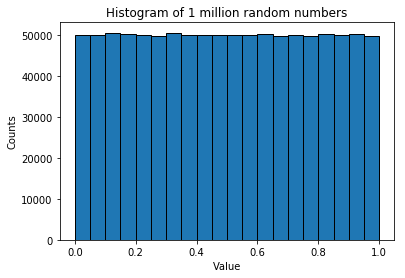

In [9]:
all_randnum = []
for i in range(int(1e6)):
    all_randnum.append(RNGESUS.get_randomnumber())
    
print( "Is np.linspace allowed?" )
plt.hist(all_randnum,bins=np.linspace(0,1,21),edgecolor='black')
plt.title(f'Histogram of 1 million random numbers')
plt.xlabel('Value')
plt.ylabel('Counts')
plt.savefig('q1b2.png')
plt.show();

# Question 2

In [10]:
# Randomly generate a,b,c within asked bounds
a = RNGESUS.get_randomnumber()*(2.5-1.1) + 1.1
b = RNGESUS.get_randomnumber()*(2.0-0.5) + 0.5
c = RNGESUS.get_randomnumber()*(4-1.5) + 1.5

print (f'a, b, c = {a,b,c}')

a, b, c = (1.8850024988161098, 0.9551760426160483, 3.079176929083844)


In [11]:
def numbdensprofile(x, a, b, c, A=1, Nsat = 100, spherical=False):
    """
    Returns the number density profile from the assignment
    
    a controls small-scale slope
    b contols transition scale
    c controls steepness of exponential dropoff
    spherical -- True to multiply by x**2 for the spherical integral
    """
    if spherical:
        power = 1
    else:
        power = 3
        
    return A*Nsat * (x/b)**(a-power) * np.exp(-(x/b))**c

In [12]:
def trapezoid(func,lbound,ubound,N=100):
    """
    Calculate the integral of a function using the trapezoid rule
    with equal spaced abscissae
    
    func -- function which gives the y values
    lbound -- lower bound of integral
    ubound -- upper bound of integral
    N      -- number of abscissae
    
    """
    xvalues = np.linspace(lbound,ubound,N)
    delta_x = (ubound-lbound)/(N-1)
    # first point
    integral = func(lbound)/2
    # all middle points
    for x in xvalues[1:-1]:
        integral += func(x)
    # endpoint
    integral += func(xvalues[-1])/2
    integral *= delta_x
    
    return integral

In [13]:
def romberg(func, lbound, ubound, order=6):
    """
    Calculate the integral of a function using Romberg's method
    with equal spaced abscissae
    
    func -- function which gives the y values
    lbound -- lower bound of integral
    ubound -- upper bound of integral
    N      -- number of abscissae
    
    efficiency:
    http://homen.vsb.cz/~lud0016/NM/Lecture_Notes_10-Romberg_Integration.pdf
    
    Returns 
     Value of the integral
     Error estimate
     
    The error estimate is given as the difference between last 2 orders
    """
    
    # for saving S_i,j's
    all_S = np.zeros((order,order))
    
    i = 0
    delta_x = (ubound-lbound)
    points = np.linspace(lbound,ubound,2**i+1)
    integral = delta_x/2 * np.sum(func(points))
    all_S[0,0] = integral
    
    # Then calculate the first column (S_{i,0})
    for i in range(1,order):
        delta_x /= 2
        # add points in the middle
        points = np.linspace(lbound,ubound,2**i+1)
        # add new points to the integral (om en om, starting from 1)
        integral = 0.5*integral + delta_x * np.sum(func(points[1::2]))
        
        all_S[i,0] = integral
    
    for j in range(1,order): # columns
        for i in range(j,order): # rows
            #print (i,j)
            #print (f'{4**j}*S{i},{j-1} - S{i-1},{j-1} / {4**j} - 1' )
            all_S[i,j] = (4**j*all_S[i,j-1] - all_S[i-1,j-1]) / (
                           4**j - 1)

    # compare this for the error function with the slides. 
    # print (all_S)
    
    return all_S[order-1,order-1], (all_S[order-1,order-1]-all_S[order-1,order-2])
        


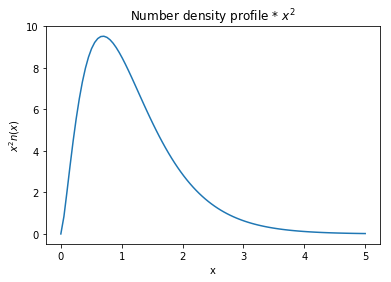

Trapezoid:
14.521450360583453
Romberg:
14.52285947373608 -1.31498e-10


In [14]:
#### This cell can be deleted later ###############

a = 2.45
b = 1.29
c = 2.70

# WolframAlpha input:
# integrate ( 100 * (x/b)**(a-3) * exp(-(x/b)**c)  ) from 0 to 5 where a = 2.4545593364474785, b = 1.2954526977495828, c = 2.700255764586844

xs = np.linspace(0.001,5,100)
plt.plot(xs, numbdensprofile(xs, a, b, c,spherical=True))
plt.title('Number density profile * $x^2$')
plt.xlabel('x')
plt.ylabel('$x^2 n(x)$')
plt.show();

# integral is only a function of R so add the prefactor manually
prefactor = 4*np.pi # integral over theta and phi
print ("Trapezoid:")
print (trapezoid(lambda x:  numbdensprofile(x, a, b, c, spherical=True)
                 , 0, 5,N=100))

print ("Romberg:")
integ, error = romberg(lambda x: numbdensprofile(x, a, b, c, spherical=True)
               , 0, 5,order=10)
print (integ, f'{error:.5e}')


In [15]:
# Randomly generate a,b,c within asked bounds
a = RNGESUS.get_randomnumber()*(2.5-1.1) + 1.1
b = RNGESUS.get_randomnumber()*(2.0-0.5) + 0.5
c = RNGESUS.get_randomnumber()*(4-1.5) + 1.5

# integral is only a function of R so add the prefactor manually
prefactor = 4*np.pi # integral over theta and phi
Nsat = 100
print ("For the following ")
print (f'a, b, c = {a,b,c}')
# print ("Romberg integration gives:")
integ, error = romberg(lambda x: numbdensprofile(x, a, b, c, Nsat=Nsat
                        , spherical=True) , 0, 5,order=10)
integ *= prefactor
# Normalize such that the integral produces <Nsat>
A = Nsat/integ
print (f"A = {A}")

For the following 
a, b, c = (1.1132884107646899, 1.250296832286201, 1.7885721190002482)
A = 0.12890948821849427


### Make a loglog plot of and plot single points for n(1e-4), n(1e-2), n(1e-1), n(1) and n(5)

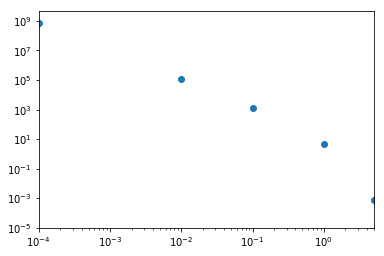

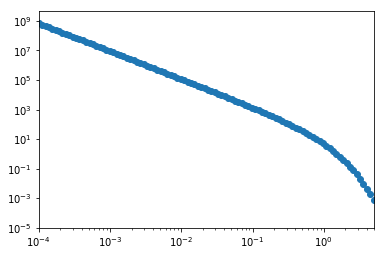

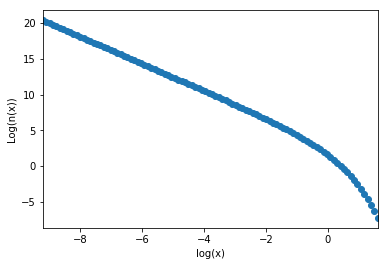

In [32]:
points = np.array([1e-4, 1e-2, 1e-1, 1, 5])
function = lambda x: numbdensprofile(x,a,b,c,A=A,Nsat=Nsat,spherical=False)
yvalues = function(points)
plt.scatter(points,yvalues)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-4,5)
plt.ylim(1e-5,5e9)
plt.show();

# Testing
xtrue = np.logspace(np.log10(1e-4),np.log10(5),100)
yvalues_true = function(xtrue)
plt.scatter(xtrue,yvalues_true)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-4,5)
plt.ylim(1e-5,5e9)
plt.show();

plt.scatter(np.log(xtrue),np.log(yvalues_true))
plt.xlim(np.log(1e-4),np.log(5))
plt.ylabel('Log(n(x))')
plt.xlabel('log(x)')
plt.show();

In [39]:
def linear_interpolation(x, f, num_values, begin, end, logx=False):
    """
    Interpolate given 'x' values and function 'f' at 
    'num_values' linearly separated between 'begin' and 'end'
    if logx = True, use equal width x values in logspace
    """
    # y values
    y = f(x)
    # interpolated y values
    y_values = []
    # interpolated x values
    if logx:
        x_values = np.logspace(np.log10(begin),np.log10(end),num_values)
    else:
        x_values = np.linspace(begin,end,num_values)
    
    # Interpolation
    for i in range(len(x)-1):
        # calculate slope between two points
        a = ( y[i+1] - y[i] ) / (x[i+1] - x[i])
        # take only x values between two points
        x_values_now = x_values[(x_values >= x[i]) & (x_values < x[i+1])]
        # calculate y values as linear interpolation
        y_values += list(y[i] + (x_values_now - x[i])*a)
        
    # Extrapolation, is simply extrapolating final bin
    x_values_now = x_values[(x_values >= x[i+1])]
    y_values += list(y[i] + (x_values_now - x[i])*a)
    
    return x_values, np.asarray(y_values)

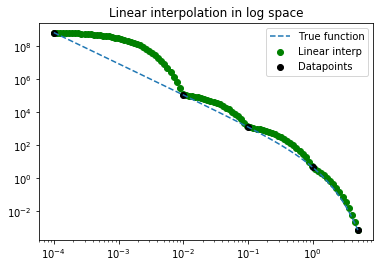

In [40]:
# Fit in log space
# logpoints = np.log(points)
logfunc = lambda x: np.log(function(x))
x_values, y_values = linear_interpolation(points,logfunc
                            , 100, 1e-4, 5, logx=True)

plt.scatter(x_values,np.exp(y_values),label='Linear interp',c='g')
plt.plot(xtrue, yvalues_true,label='True function', ls='dashed')
plt.scatter(points,yvalues, c='k',label='Datapoints')
plt.legend()
plt.title('Linear interpolation in log space')
plt.xscale('log')
plt.yscale('log')
plt.show();

In [42]:
def recurrence_relation(i, j, x, all_x, f):
    """
    Neville's algorithm recurrence relation
    i,j -- int   -- index of the datapoints 
    x   -- float -- x value to evaluate
    all_x -- array -- data points x
    f   -- function -- function that calculates y(x)
    """
    if i == j:
        # return y_i
        return f(all_x[i])
    else:
        # return the recursive relation
        return ( ((x - all_x[j])*recurrence_relation(i, j-1, x, all_x, f) 
         - (x-all_x[i])*recurrence_relation(i+1, j, x, all_x, f)) /
        (all_x[i] - all_x[j]) ) 

/home/erik/miniconda3/envs/kerastf/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


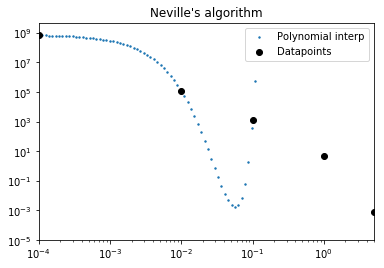

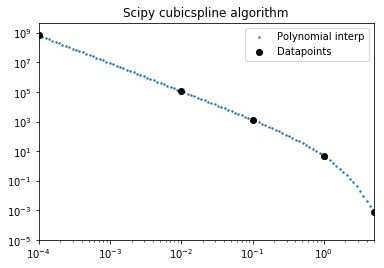

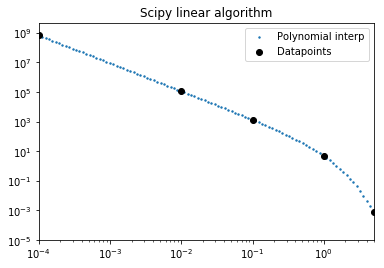

In [55]:
x_values = np.logspace(np.log10(1e-4), np.log10(5), 100)
# Calculate the y values accompanying the x values with Neville algorithm
y_values = [recurrence_relation(0,len(points)-1, x_values[i], points, 
            logfunc) for i in range(len(x_values)) ]

plt.scatter(x_values, np.exp(y_values), label='Polynomial interp', s=2)
# plt.plot(xtrue, yvalues_true,label='True function', ls='dashed',c='C1')
plt.scatter(points,yvalues,c='k',label='Datapoints')
plt.legend()

plt.title("Neville's algorithm")
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-4,5)
plt.ylim(1e-5,5e9)
plt.show()


cs = interpolate.CubicSpline(x_values,logfunc(x_values))

plt.scatter(x_values, np.exp(cs(x_values)), label='Polynomial interp', s=2)
# plt.plot(xtrue, yvalues_true,label='True function', ls='dashed',c='C1')
plt.scatter(points,yvalues,c='k',label='Datapoints')
plt.legend()

plt.title("Scipy cubicspline algorithm")
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-4,5)
plt.ylim(1e-5,5e9)
plt.show()

lin = interpolate.interp1d(x_values,logfunc(x_values),kind='linear')

plt.scatter(x_values, np.exp(lin(x_values)), label='Polynomial interp', s=2)
# plt.plot(xtrue, yvalues_true,label='True function', ls='dashed',c='C1')
plt.scatter(points,yvalues,c='k',label='Datapoints')
plt.legend()

plt.title("Scipy linear algorithm")
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-4,5)
plt.ylim(1e-5,5e9)
plt.show()




In [57]:
print (np.exp(lin(x_values))[:10] == np.exp(cs(x_values))[:10])
print (lin, cs)

[ True  True  True  True  True  True  True  True  True  True]
<scipy.interpolate.interpolate.interp1d object at 0x7f5e3af25098> <scipy.interpolate._cubic.CubicSpline object at 0x7f5e3ac6de60>
